# Data Transformation by Concept Hierarchies

> Hands‑on demo to accompany the slide **‘Data Transformation by Concept Hierarchies’**.

**What you will learn**
- What a **concept hierarchy** is (levels of detail: fine → coarse)
- How to **roll up** (aggregate to a higher level) and **drill down** (show more detail)
- How to define hierarchies for **time**, **geography**, **age**, and **product**
- How to summarize with `groupby`/`pivot_table` and visualize at different levels
- How to propose **automatic levels** for numeric features via discretization (e.g., quantiles)
- Good practices and common pitfalls


## 0. Setup (packages)
Run this once in VS Code to install dependencies.

In [1]:
#%pip -q install numpy pandas matplotlib seaborn

## 1. Imports & reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (10,4)

## 2. Concept — What are Concept Hierarchies?
A **concept hierarchy** organizes values of an attribute at multiple levels of abstraction.

- **Fine** level: detailed values (e.g., city = ‘Cambridge’, age = 23, date = 2026‑02‑17).
- **Coarse** level: generalized values (e.g., province/state, age group, month).

We can **roll up** to summarize (less detail) or **drill down** to inspect specifics (more detail). This is common in OLAP/reporting, feature engineering, and interpretable analytics.

## 3. Create a small transactional dataset
We’ll simulate purchases with a few attributes so we can build several hierarchies: **time**, **geography**, **product**, and **age**.

In [3]:
# --- Synthetic data -------------------------------------------------------
n = 1200
dates = pd.date_range('2025-01-01', periods=365, freq='D')
date = np.random.choice(dates, size=n)
# geography: cities mapped to province/state and country
cities = ['Cambridge','Kitchener','Waterloo','Toronto','Ottawa',
          'Detroit','Ann Arbor','Chicago','Buffalo','Rochester']
city = np.random.choice(cities, size=n, p=[.10,.08,.07,.18,.12,.08,.07,.14,.08,.08])
# product → subcategory → category
skus = ['Tee','Jeans','Jacket','Sneakers','Boots','Laptop','Tablet','Headphones','Camera','Lens']
sku = np.random.choice(skus, size=n)
# customer age
age = np.clip(np.random.normal(38, 12, size=n), 16, 80).astype(int)
# purchase amount
amount = np.round(np.random.lognormal(mean=3.5, sigma=0.6, size=n), 2)

df = pd.DataFrame({'date': pd.to_datetime(date), 'city': city, 'sku': sku, 'age': age, 'amount': amount})
df.head()

,date,city,sku,age,amount
0,2025-04-13,Cambridge,Tablet,46,40.39
1,2025-12-15,Ann Arbor,Laptop,43,79.09
2,2025-09-28,Kitchener,Tablet,43,56.13
3,2025-04-17,Rochester,Tee,31,17.35
4,2025-03-13,Kitchener,Tee,16,75.63


## 4. Define concept hierarchies
We’ll define mapping tables/functions for **geography**, **time**, **product**, and **age**.

In [4]:
# Geography hierarchy: city → province/state → country
geo_map = {
    'Cambridge': ('Ontario','Canada'),
    'Kitchener': ('Ontario','Canada'),
    'Waterloo':  ('Ontario','Canada'),
    'Toronto':   ('Ontario','Canada'),
    'Ottawa':    ('Ontario','Canada'),
    'Detroit':   ('Michigan','USA'),
    'Ann Arbor': ('Michigan','USA'),
    'Chicago':   ('Illinois','USA'),
    'Buffalo':   ('New York','USA'),
    'Rochester': ('New York','USA'),
}

import numpy as np

df[['province','country']] = (
    df['city']
      .map(lambda c: geo_map.get(c, (np.nan, np.nan)))  # safe lookup
      .apply(pd.Series)                                 # expand the tuple
      .rename(columns={0: 'province', 1: 'country'})
)

# Time hierarchy helpers
df['year']    = df['date'].dt.year
df['quarter'] = df['date'].dt.to_period('Q').astype(str)
df['month']   = df['date'].dt.to_period('M').astype(str)
df['week']    = df['date'].dt.to_period('W').astype(str)

# Product hierarchy: sku → subcategory → category
prod_map = {
    'Tee': ('Apparel','Clothing'),
    'Jeans': ('Apparel','Clothing'),
    'Jacket': ('Apparel','Clothing'),
    'Sneakers': ('Footwear','Clothing'),
    'Boots': ('Footwear','Clothing'),
    'Laptop': ('Computers','Electronics'),
    'Tablet': ('Computers','Electronics'),
    'Headphones': ('Audio','Electronics'),
    'Camera': ('Cameras','Electronics'),
    'Lens': ('Cameras','Electronics'),
}

tmp_prod = (
    df['sku']
      .map(lambda s: prod_map.get(s, (np.nan, np.nan)))  # safe default
      .apply(pd.Series)
      .rename(columns={0: 'subcat', 1: 'category'})
)
df[['subcat','category']] = tmp_prod

# Age hierarchy: detailed age → decade → coarse groups
df['age_decade'] = (df['age']//10)*10
age_bins   = [0, 24, 39, 59, 120]
age_labels = ['youth','adult','middle','senior']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)

df.head()

,date,city,sku,age,amount,province,country,year,quarter,month,week,subcat,category,age_decade,age_group
0,2025-04-13,Cambridge,Tablet,46,40.39,Ontario,Canada,2025,2025Q2,2025-04,2025-04-07/2025-04-13,Computers,Electronics,40,middle
1,2025-12-15,Ann Arbor,Laptop,43,79.09,Michigan,USA,2025,2025Q4,2025-12,2025-12-15/2025-12-21,Computers,Electronics,40,middle
2,2025-09-28,Kitchener,Tablet,43,56.13,Ontario,Canada,2025,2025Q3,2025-09,2025-09-22/2025-09-28,Computers,Electronics,40,middle
3,2025-04-17,Rochester,Tee,31,17.35,New York,USA,2025,2025Q2,2025-04,2025-04-14/2025-04-20,Apparel,Clothing,30,adult
4,2025-03-13,Kitchener,Tee,16,75.63,Ontario,Canada,2025,2025Q1,2025-03,2025-03-10/2025-03-16,Apparel,Clothing,10,youth


## 5. Roll‑up and drill‑down examples
We’ll summarize total **amount** at increasing levels of abstraction.

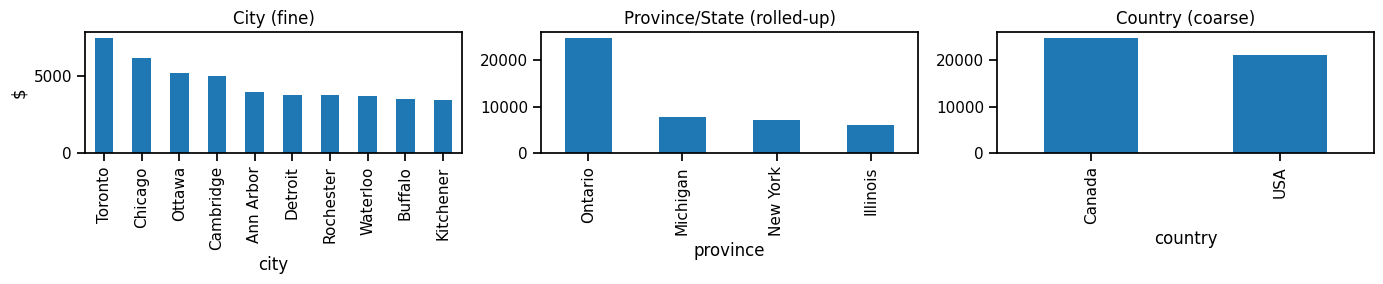

In [5]:
# Geography: city → province → country
by_city = df.groupby('city')['amount'].sum().sort_values(ascending=False)
by_prov = df.groupby('province')['amount'].sum().sort_values(ascending=False)
by_country = df.groupby('country')['amount'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1,3, figsize=(14,3))
by_city.plot(kind='bar', ax=axes[0], title='City (fine)'); axes[0].set_ylabel('$')
by_prov.plot(kind='bar', ax=axes[1], title='Province/State (rolled‑up)')
by_country.plot(kind='bar', ax=axes[2], title='Country (coarse)')
plt.tight_layout(); plt.show()

### Drill‑down: pick a province/state and view its cities

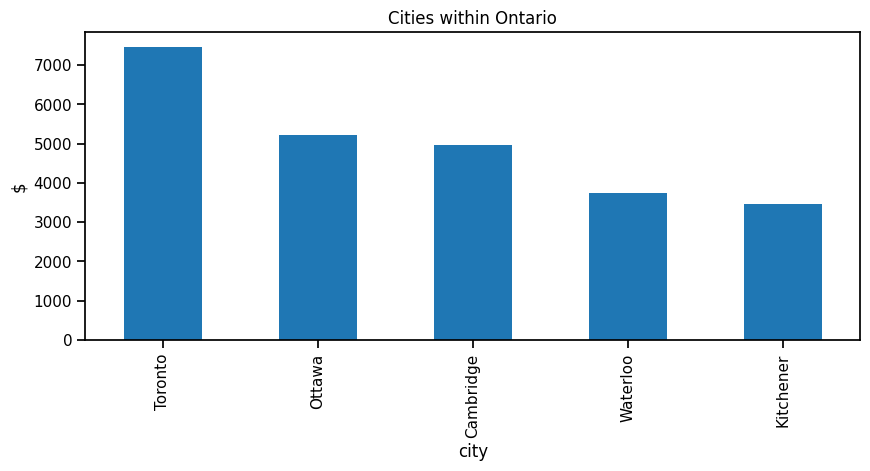

In [6]:
focus = 'Ontario'
tmp = df[df['province']==focus].groupby('city')['amount'].sum().sort_values(ascending=False)
ax = tmp.plot(kind='bar', title=f'Cities within {focus}')
ax.set_ylabel('$'); plt.show()

## 6. Time hierarchy: day → month → quarter (roll‑up)

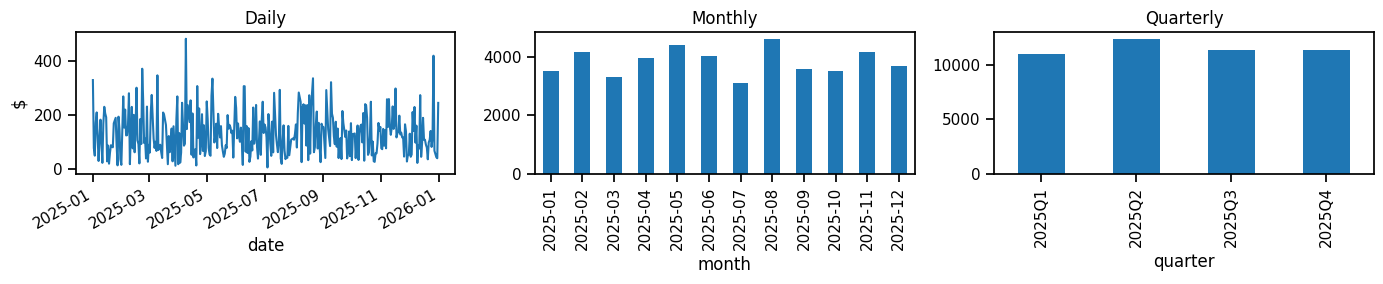

In [7]:
by_day = df.groupby('date')['amount'].sum().sort_index()
by_month = df.groupby('month')['amount'].sum()
by_quarter = df.groupby('quarter')['amount'].sum()

fig, axes = plt.subplots(1,3, figsize=(14,3))
by_day.plot(ax=axes[0], title='Daily'); axes[0].set_ylabel('$')
by_month.plot(kind='bar', ax=axes[1], title='Monthly')
by_quarter.plot(kind='bar', ax=axes[2], title='Quarterly')
plt.tight_layout(); plt.show()

## 7. Product and Demographics: multi‑level pivots
We can combine hierarchies: e.g., **category** × **month** revenue, or **age_group** × **category**.

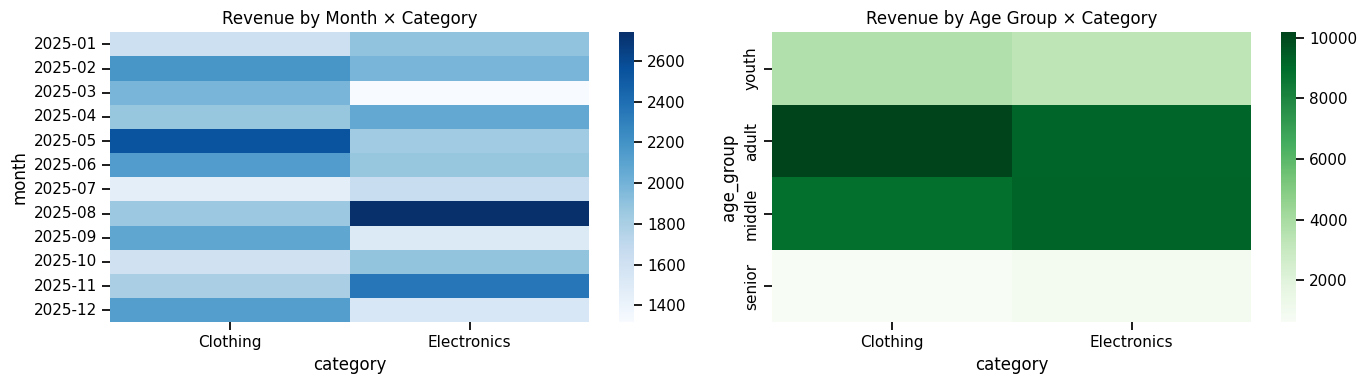

category,Clothing,Electronics
month,,
2025-01,1619.52,1900.32
2025-02,2184.01,1983.25
2025-03,1982.93,1317.15
2025-04,1873.55,2062.87
2025-05,2549.66,1838.30


In [8]:
pivot1 = pd.pivot_table(df, values='amount', index='month', columns='category', aggfunc='sum').fillna(0)
pivot2 = pd.pivot_table(df, values='amount', index='age_group', columns='category', aggfunc='sum').fillna(0)
fig, axes = plt.subplots(1,2, figsize=(14,4))
sns.heatmap(pivot1, cmap='Blues', ax=axes[0]); axes[0].set_title('Revenue by Month × Category')
sns.heatmap(pivot2, cmap='Greens', ax=axes[1]); axes[1].set_title('Revenue by Age Group × Category')
plt.tight_layout(); plt.show()
pivot1.head()

## 8. Automatic levels for numeric features (quantile discretization)
For continuous attributes (like **age**), we can propose higher‑level categories automatically using **quantiles**. This is similar to discretization and can act like a data‑driven concept hierarchy.

In [9]:
df['age_q4'] = pd.qcut(df['age'], q=4, labels=['Q1','Q2','Q3','Q4'])
df.groupby('age_q4')['amount'].mean().round(2)


age_q4
Q1    40.28
Q2    38.34
Q3    37.56
Q4    36.83
Name: amount, dtype: float64

## 9. Helper: tiny roll‑up function
Here’s a small helper to **summarize** any column at a chosen level and plot results.

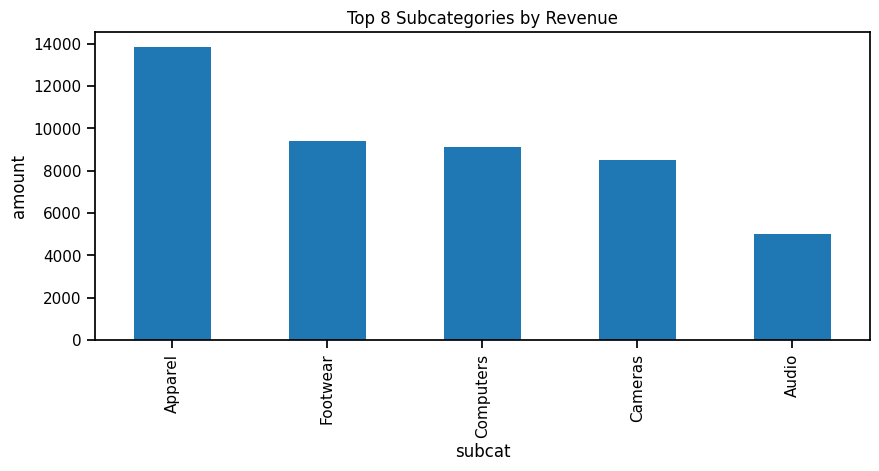

In [10]:
def rollup_plot(df, level_col, value='amount', kind='bar', top=None, title=None):
    s = df.groupby(level_col)[value].sum().sort_values(ascending=False)
    if top: s = s.head(top)
    ax = s.plot(kind=kind, title=title or f'Sum of {value} by {level_col}')
    ax.set_ylabel(value); plt.show();
    return s

_ = rollup_plot(df, 'subcat', top=8, title='Top 8 Subcategories by Revenue')


## 10. Good practices & caveats
- **Define levels with business meaning** (e.g., geographic or product taxonomies).
- **Avoid double‑counting** when rolling up across multiple dimensions simultaneously.
- **Store mapping tables** so the same roll‑ups are reproducible across training/serving.
- **Beware inappropriate generalization**: rolling up can hide minority patterns and outliers.
- For continuous data, **discretization** can create levels, but check that bins make sense to humans.

## 11. Practice exercises
1. Add a `year` × `category` heatmap and describe one insight.
2. Change the age groups to `{'teen':[13,19], '20s':[20,29], ...}` and compare revenue patterns.
3. Add a new **hierarchy level** for product (e.g., department → super‑department) and re‑run summaries.
4. Create a `drill_down(df, level, filter_col, filter_val)` helper that filters then groups.
5. (Challenge) Build a small **Sankey‑style** table that shows flows from city → province → country using counts.

---
_Last updated: 2026-02-17 20:51:00 UTC_
